# SNR Threshold Finder Example

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gwsnr.threshold import SNRThresholdFinder

np.random.seed(1234)

In [ ]:
# Example if you have the injection catalog file locally
# you can download the file for O4 injections from zenodo:
# !wget https://zenodo.org/records/16740117/files/samples-rpo4a_v2_20250503133839UTC-1366933504-23846400.hdf?download=1

# file_name = 'samples-rpo4a_v2_20250503133839UTC-1366933504-23846400.hdf'

# test = SNRThresholdFinder(
#     catalog_file = file_name,
#     # # below are all default values. You can omit them if you want. 
#     # npool=4,
#     # original_detection_statistic = dict(
#     #             key_name='gstlal_far',
#     #             threshold=1,  # 1 per year
#     #             parameter=None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     #         ),
#     # projected_detection_statistic = dict(
#     #             key_name='observed_snr_net',
#     #             threshold=None, # to be determined
#     #             threshold_search_bounds=(6, 12),
#     #             parameter=None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     #         ),
#     # parameters_to_fit = dict(
#     #     key_name = 'z',
#     #     parameter=None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     # ),
#     # sample_size=20000,
#     # selection_range = dict(
#     #     key_name = 'mass1_source',
#     #     range = (30, 60), # in solar masses
#     #     parameter = None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     # ),
#     # sample_size=20000,
#     # multiprocessing_verbose=True,
# )

In [ ]:
# injection_data.json is the reduced data extracted from the above hdf file for testing purpose
! wget https://github.com/hemantaph/gwsnr/blob/main/tests/unit/injection_data.json

--2025-10-28 12:43:16--  https://github.com/hemantaph/gwsnr/blob/main/tests/unit/injection_data.json
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘injection_data.json’

injection_data.json     [ <=>                ] 181.76K  --.-KB/s    in 0.1s    

2025-10-28 12:43:17 (1.86 MB/s) - ‘injection_data.json’ saved [186125]



In [ ]:

params = load_json('injection_data.json')

# far = params['gstlal_far']
# snr_net = params['observed_snr_net']
# z = params['z']
# mass1_source = params['mass1_source']

JSONDecodeError: Expecting value: line 7 column 1 (char 6)

In [ ]:
test = SNRThresholdFinder(
    catalog_file = None,
    # below are all default values. You can omit them if you want. 
    npool=4,
    original_detection_statistic = dict(
                key_name='gstlal_far',
                threshold=1,  # 1 per year
                parameter=,
            ),
    projected_detection_statistic = dict(
                key_name='observed_snr_net',
                threshold=None, # to be determined
                threshold_search_bounds=(6, 12),
                parameter=,
            ),
    parameters_to_fit = dict(
        key_name = 'z',
        parameter=,
    ),
    sample_size=20000,
    selection_range = dict(
        key_name = 'mass1_source',
        range = (30, 60), # in solar masses
        parameter = ,
    ),
)

In [11]:
best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]

Best SNR threshold: 10.10


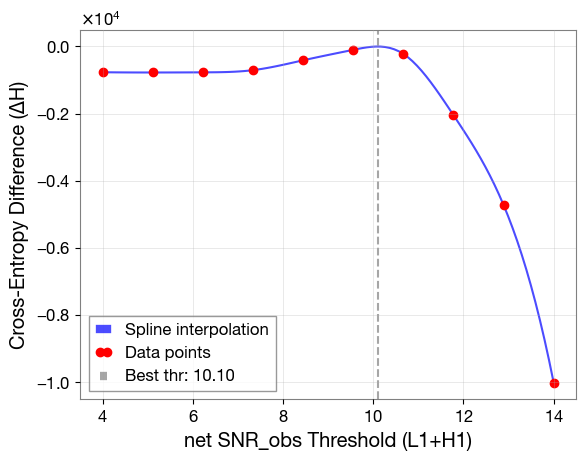

In [12]:
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt

spline = UnivariateSpline(snr_thrs, del_H, s=0)
snr_fine = np.linspace(snr_thrs.min(), snr_thrs.max(), 100)
del_H_fine = spline(snr_fine)
plt.plot(snr_fine, del_H_fine, 'b-', alpha=0.7, label='Spline interpolation')
plt.plot(snr_thrs, del_H, 'ro', markersize=6, label='Data points')
plt.axvline(best_thr, color='gray', linestyle='--', alpha=0.7, label=f'Best thr: {best_thr:.2f}')
plt.xlabel('net SNR_obs Threshold (L1+H1)')
plt.ylabel('Cross-Entropy Difference (ΔH)')
plt.grid(alpha=0.4) 
plt.legend()
plt.show()

### Visualizing how well the detectable population matches when using SNRth and FAR cutoffs as detection criteria

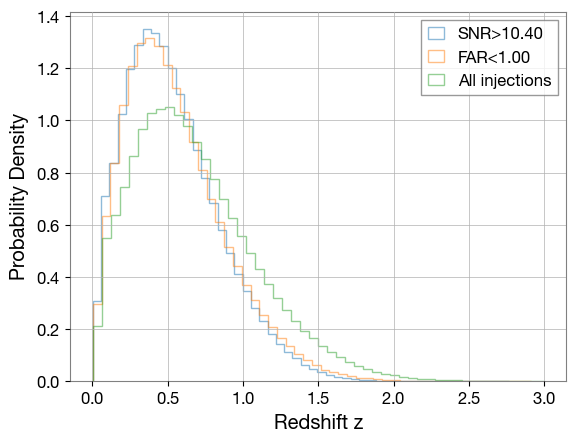

In [16]:
snr_th = best_thr
with h5py.File(file_name, 'r') as obj:
    attrs = dict(obj.attrs.items())
    events = obj['events'][:]

z = events['z']
observed_snr_net = events['observed_snr_net']
plt.hist(z[observed_snr_net>=snr_th], bins=50, density=True, alpha=0.5, color='C0', histtype='step', label=f'SNR>{best_thr:.2f}')
far_th = 1
gstlal_far = events['gstlal_far']
plt.hist(z[gstlal_far<far_th], bins=50, density=True, alpha=0.5, color='C1', histtype='step', label=f'FAR<{far_th:.2f}')
plt.hist(z, bins=50, density=True, alpha=0.5, color='C2', histtype='step', label='All injections')
plt.xlabel('Redshift z')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [ ]:
# # check rates
# with h5py.File(file_name, 'r') as obj:
#     attrs = dict(obj.attrs.items())
#     events = obj['events'][:]

# observed_snr_net = events['observed_snr_net']
# gstlal_far = events['gstlal_far']

# fraction_above_snr_thresh = np.sum(observed_snr_net >= best_thr) / len(observed_snr_net)
# fraction_above_gstlal_far = np.sum(gstlal_far < 1) / len(observed_snr_net)

# print(f"Fraction above SNR threshold {best_thr:.2f}: {fraction_above_snr_thresh:.6f}")
# print(f"Fraction above GstLAL FAR threshold 1 per year: {fraction_above_gstlal_far:.6f}")

Fraction above SNR threshold 10.40: 0.522918
Fraction above GstLAL FAR threshold 1 per year: 0.286787


## Mass dependent SNR thresholds

In [24]:
with h5py.File(file_name, 'r') as obj:
    attrs = dict(obj.attrs.items())
    events = obj['events'][:]

mass1_source = events['mass1_source']
mass1_source.min(), mass1_source.max()

(1.0011182390093958, 992.5473451410022)

In [25]:
cuts = np.linspace(6, 14, 10)
mass_points = np.geomspace(1, 200, 20)
mass_range = [[mass_points[i], mass_points[i+1]] for i in range(len(mass_points)-1)]

best_cuts = []

def objective(min_mass, max_mass,):
    
    test = SNRThresholdFinder(
        catalog_file = file_name,
        selection_range = dict(
            key_name = 'mass1_source',
            range = (min_mass, max_mass),
        ),
    )

    best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

    return best_thr

for mass_min, mass_max in mass_range:
    print(f"Mass range: {mass_min:.1f} - {mass_max:.1f}")

    best_cut = objective(mass_min, mass_max)

    best_cuts.append(best_cut)
best_cuts = np.array(best_cuts)

Mass range: 1.0 - 1.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.30it/s]


Best SNR threshold: 13.15
Mass range: 1.3 - 1.7


100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


Best SNR threshold: 10.78
Mass range: 1.7 - 2.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


Best SNR threshold: 12.20
Mass range: 2.3 - 3.1


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.22it/s]


Best SNR threshold: 11.64
Mass range: 3.1 - 4.0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Best SNR threshold: 11.33
Mass range: 4.0 - 5.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


Best SNR threshold: 11.29
Mass range: 5.3 - 7.0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


Best SNR threshold: 11.20
Mass range: 7.0 - 9.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.98it/s]


Best SNR threshold: 11.36
Mass range: 9.3 - 12.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Best SNR threshold: 11.24
Mass range: 12.3 - 16.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


Best SNR threshold: 10.21
Mass range: 16.3 - 21.5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Best SNR threshold: 10.12
Mass range: 21.5 - 28.4


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Best SNR threshold: 9.67
Mass range: 28.4 - 37.5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Best SNR threshold: 9.28
Mass range: 37.5 - 49.6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


Best SNR threshold: 9.69
Mass range: 49.6 - 65.6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Best SNR threshold: 9.87
Mass range: 65.6 - 86.6


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


Best SNR threshold: 10.46
Mass range: 86.6 - 114.5


100%|███████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]


Best SNR threshold: 11.15
Mass range: 114.5 - 151.3


100%|███████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


Best SNR threshold: 12.01
Mass range: 151.3 - 200.0


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.94it/s]

Best SNR threshold: 12.70


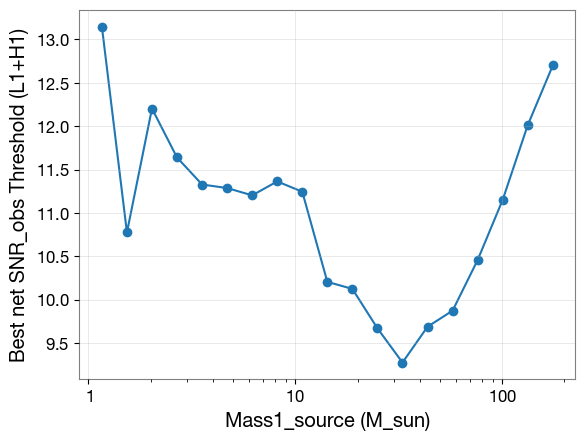

In [30]:
# plot mass vs best cuts
plt.plot([0.5*(mass_range[i][0]+mass_range[i][1]) for i in range(len(mass_range))], best_cuts, 'o-')
plt.xscale('log')
plt.xlabel('Mass1_source (M_sun)')
plt.ylabel('Best net SNR_obs Threshold (L1+H1)')
plt.grid(alpha=0.4)
plt.show()